In [1]:
#数据准备
import numpy as np
import xarray as xr
import netCDF4 as nc
import pandas as pd
import math
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from metpy import units
from netCDF4 import Dataset
import metpy.constants as constants
import metpy.calc as mpcalc
import cartopy.io.shapereader as shpreader
from matplotlib.path import Path
from cartopy.mpl.patch import geos_to_path
from metpy.interpolate import inverse_distance_to_grid
from scipy.interpolate import griddata
from scipy.interpolate import Rbf
from scipy import stats
import scipy.ndimage as ndimage
from mpl_toolkits.basemap import Basemap
import time
from matplotlib.dates import DateFormatter
from matplotlib.colors import ListedColormap, BoundaryNorm
import cftime
import mpath
import matplotlib.path as mpath
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import os
import glob
import dask.array as da
import cmaps
import import_ipynb
from cartopy.util import add_cyclic_point
from matplotlib import rcParams
import sys
sys.path.append(r'C:\zjh\Python\jupyterProject\jupyterProject')
import code_study as cs
from datetime import datetime as dt
from datetime import timedelta
from matplotlib.ticker import FixedLocator
# %run code_study.ipynb
from minisom import MiniSom

In [2]:
def TM90(lonl,lonr,data0):
    delta=np.array([-5, 0, 5])
    data=data0.sel(lon=slice(lonl,lonr))
    TM90=xr.zeros_like(data.sel(lat=60))
    G_S_all=[]
    G_N_all=[]
    for dl in delta:
        phi_n=70+dl
        phi_o=57.5+dl
        phi_s=45+dl
        G_S=(data.sel(lat=phi_o)- data.sel(lat=phi_s).values) / (phi_o - phi_s)
        G_N=(data.sel(lat=phi_n)- data.sel(lat=phi_o).values) / (phi_n - phi_o)
        G_S_all.append(G_S)
        G_N_all.append(G_N)
        condition = (G_S > 0) & (G_N < -10)
        TM90 = TM90.where(~condition, 1) #保留condition为True的值，其他位置替换为1
    return TM90,G_S_all, G_N_all
# 乌拉尔地区：30-90°E 45-70°N.

In [3]:
def data_all(lat1,lat2,lon1,lon2,year,allyear,var):
 
    path=r'D:\data\Data_concat\\'+str(year)+'_'+var+'\\'+var+'_1979_'+str(year-1)+'03.nc'
    isExists=os.path.exists(path)
    if not isExists:
        os.mkdir(path)
        files=glob.glob('E://data//ERA5.daily.1x1//'+var+'//'+var+'.*.nc')[12*(year-1979-allyear)+3:12*(year-1979)+3]
        data_scatter=[]
        lon_c=np.arange(-360,360,1)
        for file in files:  #按照顺序在 files 里面进行每一个文件的 数据名称 循环读取
            f=xr.open_dataset(file)  # 打开第一个文件
            if var=='Z':
                if f.g0_lon_3[-1]>300:
                    data_c=np.tile(f[var].loc[:,500,:,:],(1,1,2))
                    data_dac=xr.DataArray(data_c,coords=[f.initial_time0_hours,f.g0_lat_2,lon_c],dims=['time','lat','lon'])
                    t0=data_dac.loc[:,lat1:lat2,lon1:lon2]/9.8
                else:
                    uf1c,lonc=add_cyclic_point(f[var].loc[:,500,:,:],coord=f.g0_lon_3, axis=-1)
                    data_dac=xr.DataArray(uf1c,coords=[f.initial_time0_hours,f.g0_lat_2,lonc],dims=['time','lat','lon'])
                    t0=data_dac.loc[:,lat1:lat2,lon1:lon2]/9.8
            else:
                if f.g0_lon_2[-1]>300:
                    data_c=np.tile(f[var],(1,1,2))
                    data_dac=xr.DataArray(data_c,coords=[f.initial_time0_hours,f.g0_lat_1,lon_c],dims=['time','lat','lon'])
                    t0=data_dac.loc[:,lat1:lat2,lon1:lon2]   
                else:
                    uf1c,lonc=add_cyclic_point(f[var],coord=f.g0_lon_2, axis=-1)
                    data_dac=xr.DataArray(uf1c,coords=[f.initial_time0_hours,f.g0_lat_1,lonc],dims=['time','lat','lon'])
                    t0=data_dac.loc[:,lat1:lat2,lon1:lon2]
            data_scatter.append(t0)
        t1=xr.concat(data_scatter,dim='time')
        mask=(t1.time.dt.month.isin([2])&t1.time.dt.day.isin([29]))
        t=t1.loc[~mask]
        if var=='Z':
            lat=t.lat.loc[lat1:lat2]
            lon=t.lon.loc[lon1:lon2]
        else:
            lat=t.lat.loc[lat1:lat2]
            lon=t.lon.loc[lon1:lon2]
        t_cli=t.values.reshape(allyear,365,len(lat),len(lon))
        time=pd.date_range('2010-04-01','2011-03-31',freq='D')
        t_cli_nc=xr.DataArray(t_cli,coords=[np.arange(1979,1979+allyear),time,lat,lon],dims=['year','time','lat','lon'],name=var+'_cli')
        t_cli_nc.to_netcdf(path+'\\'+var+'_1979_'+str(year-1)+'03.nc')
    elif var=='Z':
        t_cli_nc=xr.open_dataset(path+'\\'+var+'_1979_'+str(year-1)+'03.nc').Z_cli
    else:
        t_cli_nc=xr.open_dataset(path+'\\'+var+'_1979_'+str(year-1)+'03.nc').T2m_cli
    return t_cli_nc

In [4]:
data=data_all(0,90,-180,180,2025,46,'Z').interp(lat=np.arange(0,91,2.5),lon=np.arange(-180,181,2.5),method='linear')
data_cli=data.sel(year=slice(1979,2008))
data_cli_timean=data_cli.mean(dim='year')
data_cli_ano_all=data-data_cli_timean
data_cli_ano=data_cli_ano_all.sel(time=slice('2010-12-01','2011-02-28'))
TM90,G_S,G_N=TM90(30,90,data_cli_ano)
year=TM90.year

In [5]:
event=[]
for i in range(len(TM90.year)):
    yr= int(TM90.year[i].values)
    blocking_time= TM90[i].time.where(TM90[i].sum(dim='lon')>=1)
    blocking_time= pd.to_datetime(blocking_time).to_series().apply(lambda x: x.replace(year=yr if x.year==2010 else yr+1))
    blocking_lon_center=TM90[i].lon.where(TM90[i]==1).mean(dim='lon')
    event_time=[]
    for j in range(len(TM90.time)-5):
        if np.abs(blocking_lon_center[j+1]-blocking_lon_center[j]) < 30 and np.abs(blocking_lon_center[j+2]-blocking_lon_center[j+1]) < 30 and np.abs(blocking_lon_center[j+3]-blocking_lon_center[j+2]) < 30 and np.abs(blocking_lon_center[j+4]-blocking_lon_center[j+3]) < 30 and np.abs(blocking_lon_center[j+5]-blocking_lon_center[j+4]) < 30 and blocking_time[j] not in event_time:
            event_individual=[]
            event_time.append(blocking_time[j])
            event_individual.append(blocking_time[j])
            for k in range(len(TM90.time)-j-1):
                k=k+j+1
                if np.abs(blocking_lon_center[k]-blocking_lon_center[k-1]) < 30:
                    event_time.append(blocking_time[k])
                    event_individual.append(blocking_time[k])
                else:
                    break
            event.append(event_individual)

In [6]:
time_all=pd.date_range('1979-04-01','2025-03-31',freq='D')
time_all=time_all[~(time_all.month.isin([2])&time_all.day.isin([29]))]
time_all_summer=time_all[time_all.month.isin([12,1,2])]
Z500_ano=xr.DataArray(data_cli_ano.values.reshape(46*90,37,145),coords=[time_all_summer,data_cli_ano.lat,data_cli_ano.lon],dims=['time','lat','lon'],name='Z500_ano')
Z500_ano_all=xr.DataArray(data_cli_ano_all.values.reshape(46*365,37,145),coords=[time_all,data_cli_ano.lat,data_cli_ano.lon],dims=['time','lat','lon'],name='Z500_ano_all')
lon=np.arange(-60,120.1,2.5)
lat=data_cli_ano.lat
lat_ural=np.arange(45,70.1,2.5)
Z500_event_mean=[((Z500_ano.sel(time=ti,lat=slice(45,70),lon=slice(30,90)))*np.cos(np.radians(lat_ural[np.newaxis,:,np.newaxis]))/sum(np.cos(np.radians(lat_ural)))).sum(dim=['lat']).mean(dim=['lon']) for ti in event]
Z500_ano_mean=((Z500_ano.sel(lat=slice(45,70),lon=slice(-60,120)))*np.cos(np.radians(lat_ural[np.newaxis,:,np.newaxis]))/sum(np.cos(np.radians(lat_ural)))).sum(dim=['lat'])

In [7]:
for i in range(len(Z500_event_mean)-1,-1,-1):
    if max(Z500_event_mean[i])<0:
        Z500_event_mean.pop(i)
        event.pop(i)

In [8]:

Z500_event_time_center=[max(Z500_event_mean[i]).time for i in range(len(Z500_event_mean))]

Z500_event_center_mean=[(Z500_ano_all.sel(time=slice((pd.to_datetime(Z500_event_time_center[i].values)-timedelta(days=11)).strftime('%Y-%m-%d'), (pd.to_datetime(Z500_event_time_center[i].values)+timedelta(days=15)).strftime('%Y-%m-%d')),lat=slice(45,70),lon=slice(-30,90))*np.cos(np.radians(lat_ural[np.newaxis,:,np.newaxis]))/sum(np.cos(np.radians(lat_ural)))).sum(dim=['lat']) for i in range(len(Z500_event_time_center))]

Z500_event_center_mean_all=[(Z500_ano_all.sel(time=slice((pd.to_datetime(Z500_event_time_center[i].values)-timedelta(days=16)).strftime('%Y-%m-%d'), (pd.to_datetime(Z500_event_time_center[i].values)+timedelta(days=20)).strftime('%Y-%m-%d')),lat=slice(45,70),lon=slice(-60,120))*np.cos(np.radians(lat_ural[np.newaxis,:,np.newaxis]))/sum(np.cos(np.radians(lat_ural)))).sum(dim=['lat']) for i in range(len(Z500_event_time_center))]

for i in range(len(Z500_event_time_center)):
    if len(Z500_event_center_mean[i].time) > 26:
        Z500_event_center_mean[i]=Z500_event_center_mean[i][1:]
    if len(Z500_event_center_mean_all[i].time) > 36:
        Z500_event_center_mean_all[i]=Z500_event_center_mean_all[i][1:]
    Z500_event_center_mean[i]['time']=np.arange(26*i,26*(i+1),1)
Z500_event_center_31=xr.concat(Z500_event_center_mean,dim='time')
Z500_event_center_31_kmeans=Z500_event_center_31.values.reshape(len(event),26,49).reshape(len(event),26*49)


# Self Organizing Maps 自组织映射网络聚

# 4类

轮廓系数: 0.0386937418811187
筛选后事件: [['2' 'b']
 ['3' 'c']
 ['4' 'b']
 ['5' 'c']
 ['6' 'c']
 ['7' 'c']
 ['8' 'b']
 ['9' 'd']
 ['10' 'c']
 ['11' 'a']
 ['12' 'c']
 ['13' 'c']
 ['14' 'a']
 ['15' 'a']
 ['16' 'c']
 ['18' 'd']
 ['19' 'd']
 ['20' 'b']
 ['21' 'a']
 ['22' 'c']
 ['23' 'c']
 ['24' 'c']
 ['26' 'b']
 ['27' 'c']
 ['28' 'b']
 ['29' 'd']
 ['30' 'd']
 ['31' 'c']
 ['32' 'a']
 ['33' 'a']
 ['34' 'b']
 ['35' 'b']
 ['36' 'd']
 ['37' 'c']
 ['38' 'b']
 ['39' 'd']
 ['40' 'd']
 ['41' 'c']
 ['43' 'b']
 ['44' 'b']
 ['45' 'c']
 ['46' 'a']
 ['47' 'b']
 ['48' 'a']
 ['49' 'd']
 ['50' 'b']
 ['51' 'c']
 ['52' 'd']
 ['53' 'b']
 ['54' 'c']
 ['55' 'c']
 ['56' 'd']
 ['57' 'a']
 ['58' 'a']
 ['59' 'b']
 ['62' 'c']
 ['63' 'b']
 ['64' 'c']
 ['67' 'b']
 ['68' 'c']
 ['71' 'b']
 ['72' 'd']
 ['73' 'd']
 ['74' 'c']
 ['75' 'd']
 ['76' 'a']
 ['78' 'd']
 ['79' 'd']
 ['80' 'c']
 ['81' 'a']
 ['82' 'b']
 ['83' 'b']
 ['84' 'c']
 ['86' 'c']
 ['87' 'c']
 ['88' 'd']
 ['90' 'b']
 ['91' 'd']
 ['92' 'd']
 ['93' 'c']
 ['94' 'b']
 ['9

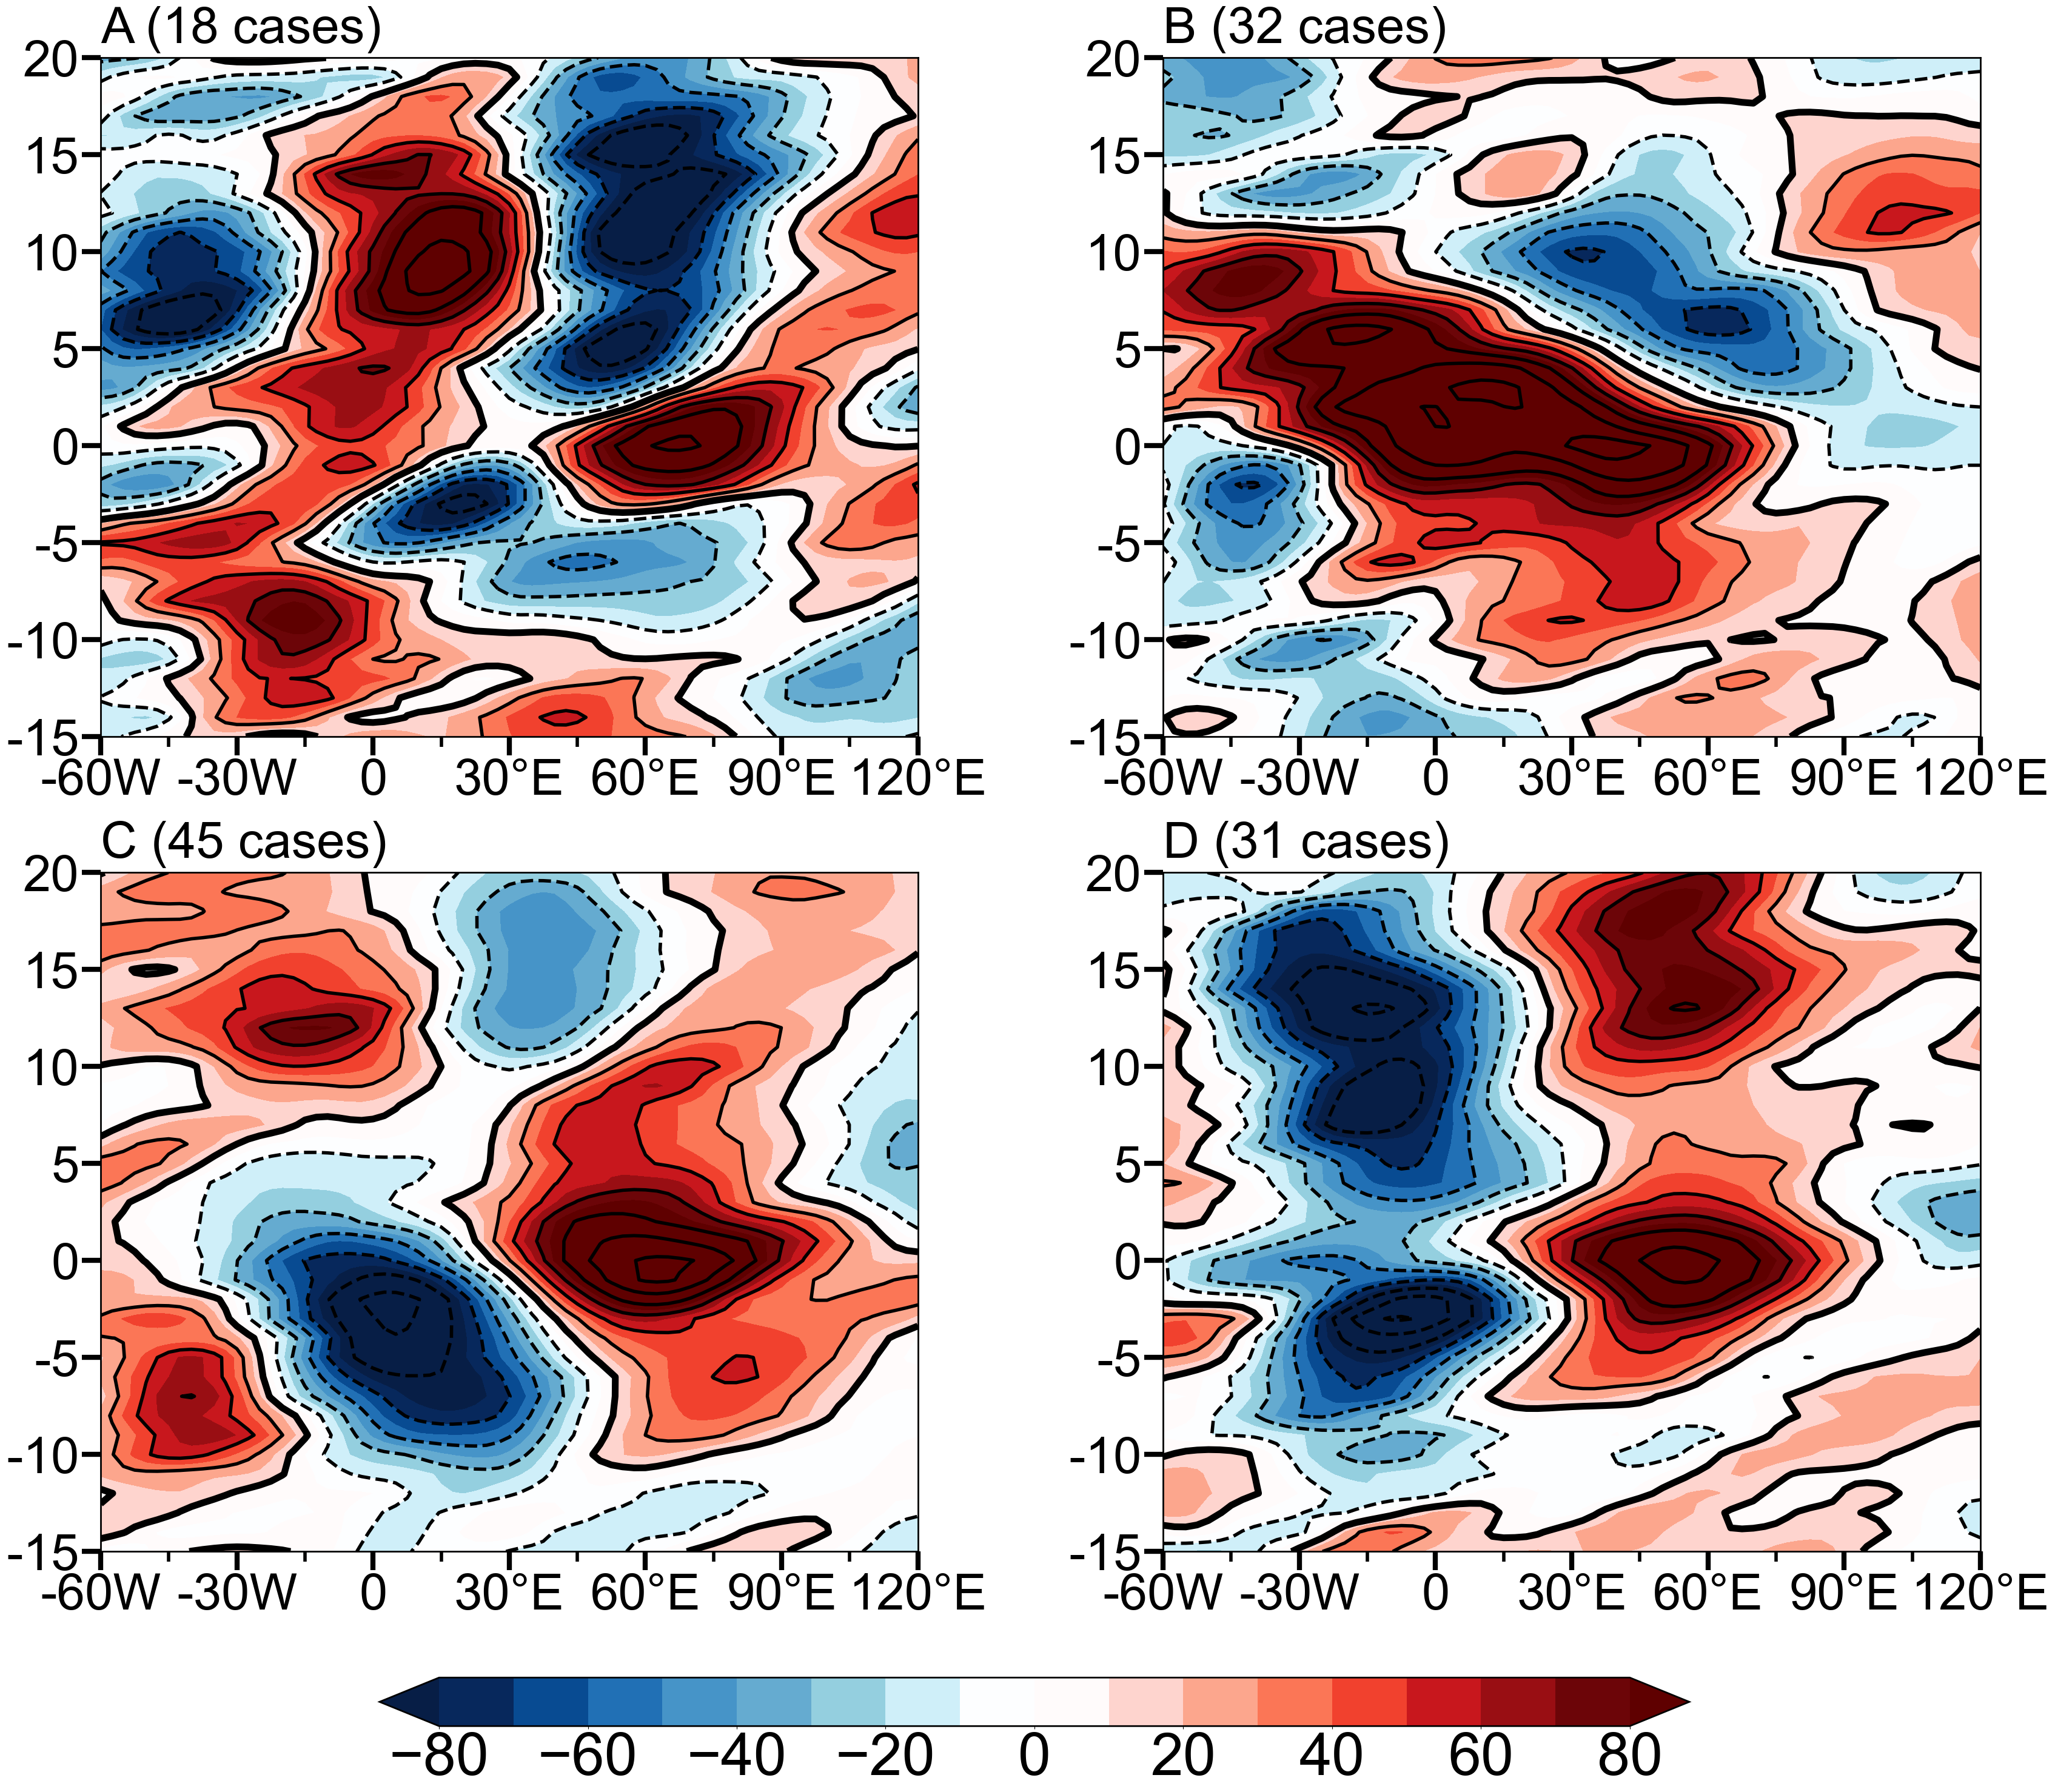

In [9]:
cluster_data = Z500_event_center_31_kmeans.copy()
som = MiniSom(x=2, y=2, input_len=1274,neighborhood_function="gaussian", sigma=2, learning_rate=0.5,random_seed=42)
# 创建一个 5x5 的 SOM
# x: 竞争层的X维度
# y: 竞争层的y维度
# input_len: 输入层的维度
# neighborhood_function：近邻函数，可选择：'gaussian', 'mexican_hat', 'bubble', 'triangle'
# sigma： 近邻函数的参数
# topology： 拓扑关系，默认是矩形关系。候选：'euclidean', 'cosine', 'manhattan', 'chebyshev'
# decay_function : 学习率的下降函数  降低学习率与缩小扩展范围使用的是同一个函数
#                   默认：(default=None) ： learning_rate / (1+t/(max_iterarations/2)
"""训练网络"""
som.train(cluster_data, 10000)



winner_coordinates = np.array([som.winner(x) for x in cluster_data])
cluster_index = np.ravel_multi_index(winner_coordinates.T, (2,2))
from sklearn.metrics import silhouette_samples, silhouette_score
silhouette_avg = silhouette_score(cluster_data, cluster_index)
print(f'轮廓系数: {silhouette_avg}')

Z500_event_center_mean_all_remv=Z500_event_center_mean_all.copy()
som_cluster_index=list(cluster_index)
event_according=list(np.arange(len(Z500_event_time_center))+1)
for cla in np.where(silhouette_samples(cluster_data, cluster_index)< 0)[0][::-1]:
    Z500_event_center_mean_all_remv.pop(cla)
    som_cluster_index.pop(cla)
    event_according.pop(cla)
som.labels_chr=[chr(ord('a')+som_cluster_index[i]) for i in range(len(som_cluster_index))]
event_filter=np.column_stack((event_according, som.labels_chr))
som_cluster_index=np.array(som_cluster_index)
print(f'筛选后事件: {event_filter}')

cluster1_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(som_cluster_index==0)[0]],dim='time').values.reshape(-1,36,73).mean(0)
cluster2_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(som_cluster_index==1)[0]],dim='time').values.reshape(-1,36,73).mean(0)
cluster3_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(som_cluster_index==2)[0]],dim='time').values.reshape(-1,36,73).mean(0)
cluster4_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(som_cluster_index==3)[0]],dim='time').values.reshape(-1,36,73).mean(0)


fig = plt.figure(figsize=(40,32))
plt.subplots_adjust(wspace=0.3)
rcParams["axes.linewidth"] = 2
rcParams['font.family'] = 'Arial'

rcParams['hatch.linewidth'] = 3  # 控制点的线宽
rcParams['hatch.color'] = 'black'  # 修改图案颜色
temperature_cmap = cmaps.temp_19lev
# 获取该色图的颜色
colors = temperature_cmap(np.linspace(0, 1, temperature_cmap.N))

# 让中间两个颜色成为白色
midpoint = len(colors) // 2  # 找到色图的中间位置
colors[midpoint-1:midpoint+1] = np.array([1, 1, 1, 1])  # 设置中间的两个颜色为白色

# 创建新的色图
temperature_cmap = mcolors.LinearSegmentedColormap.from_list("custom_temp", colors)

ax = fig.add_subplot(2,2,1)
ax.set_title('A ('+str(np.where(som_cluster_index==0)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap ,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)


ax = fig.add_subplot(2,2,2)
ax.set_title('B ('+str(np.where(som_cluster_index==1)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
c1 = ax.contourf(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)


ax = fig.add_subplot(2,2,3)
ax.set_title('C ('+str(np.where(som_cluster_index==2)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
c1 = ax.contourf(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)

ax = fig.add_subplot(2,2,4)
ax.set_title('D ('+str(np.where(som_cluster_index==3)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
c1 = ax.contourf(lon,np.arange(1,37), cluster4_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster4_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster4_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster4_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)
cb_ax = fig.add_axes([0.24, 0.02, 0.54, 0.025])  # [左, 下, 宽, 高]
cb = fig.colorbar(c1, ax=ax,cax=cb_ax,orientation='horizontal', fraction=0.05, pad=0.1) #extendrect=True
cb.ax.tick_params(labelsize=70)
cb.set_ticks(np.arange(-80,81,20))
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_DJF\Ural_blocking_Som_cluster_4_22.jpg',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_DJF\Ural_blocking_Som_cluster_4_22.pdf',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_DJF\Ural_blocking_Som_cluster_4_22.eps',dpi=300,bbox_inches='tight')

# 3类

轮廓系数: 0.03757532814714621
筛选后事件: [[  3   1]
 [  5   1]
 [  6   0]
 [  7   1]
 [  8   1]
 [  9   0]
 [ 11   2]
 [ 12   1]
 [ 13   1]
 [ 15   2]
 [ 16   1]
 [ 17   1]
 [ 18   0]
 [ 21   1]
 [ 22   1]
 [ 23   1]
 [ 25   0]
 [ 26   2]
 [ 27   1]
 [ 29   0]
 [ 30   0]
 [ 31   1]
 [ 33   2]
 [ 34   2]
 [ 35   2]
 [ 36   0]
 [ 37   1]
 [ 38   2]
 [ 39   0]
 [ 40   0]
 [ 41   1]
 [ 42   0]
 [ 43   2]
 [ 44   2]
 [ 45   1]
 [ 47   2]
 [ 49   0]
 [ 50   2]
 [ 52   0]
 [ 53   2]
 [ 55   1]
 [ 56   0]
 [ 57   1]
 [ 59   2]
 [ 60   1]
 [ 61   0]
 [ 62   1]
 [ 63   2]
 [ 65   0]
 [ 66   1]
 [ 67   2]
 [ 68   1]
 [ 69   1]
 [ 70   1]
 [ 71   2]
 [ 72   0]
 [ 73   1]
 [ 74   1]
 [ 79   0]
 [ 80   1]
 [ 83   2]
 [ 84   1]
 [ 85   1]
 [ 86   1]
 [ 87   1]
 [ 88   1]
 [ 89   1]
 [ 90   2]
 [ 91   0]
 [ 92   1]
 [ 93   1]
 [ 94   2]
 [ 95   1]
 [ 96   2]
 [ 97   0]
 [ 99   0]
 [100   1]
 [101   0]
 [103   1]
 [104   1]
 [105   1]
 [106   1]
 [107   2]
 [108   2]
 [109   0]
 [110   1]
 [112   1]
 [114   2]

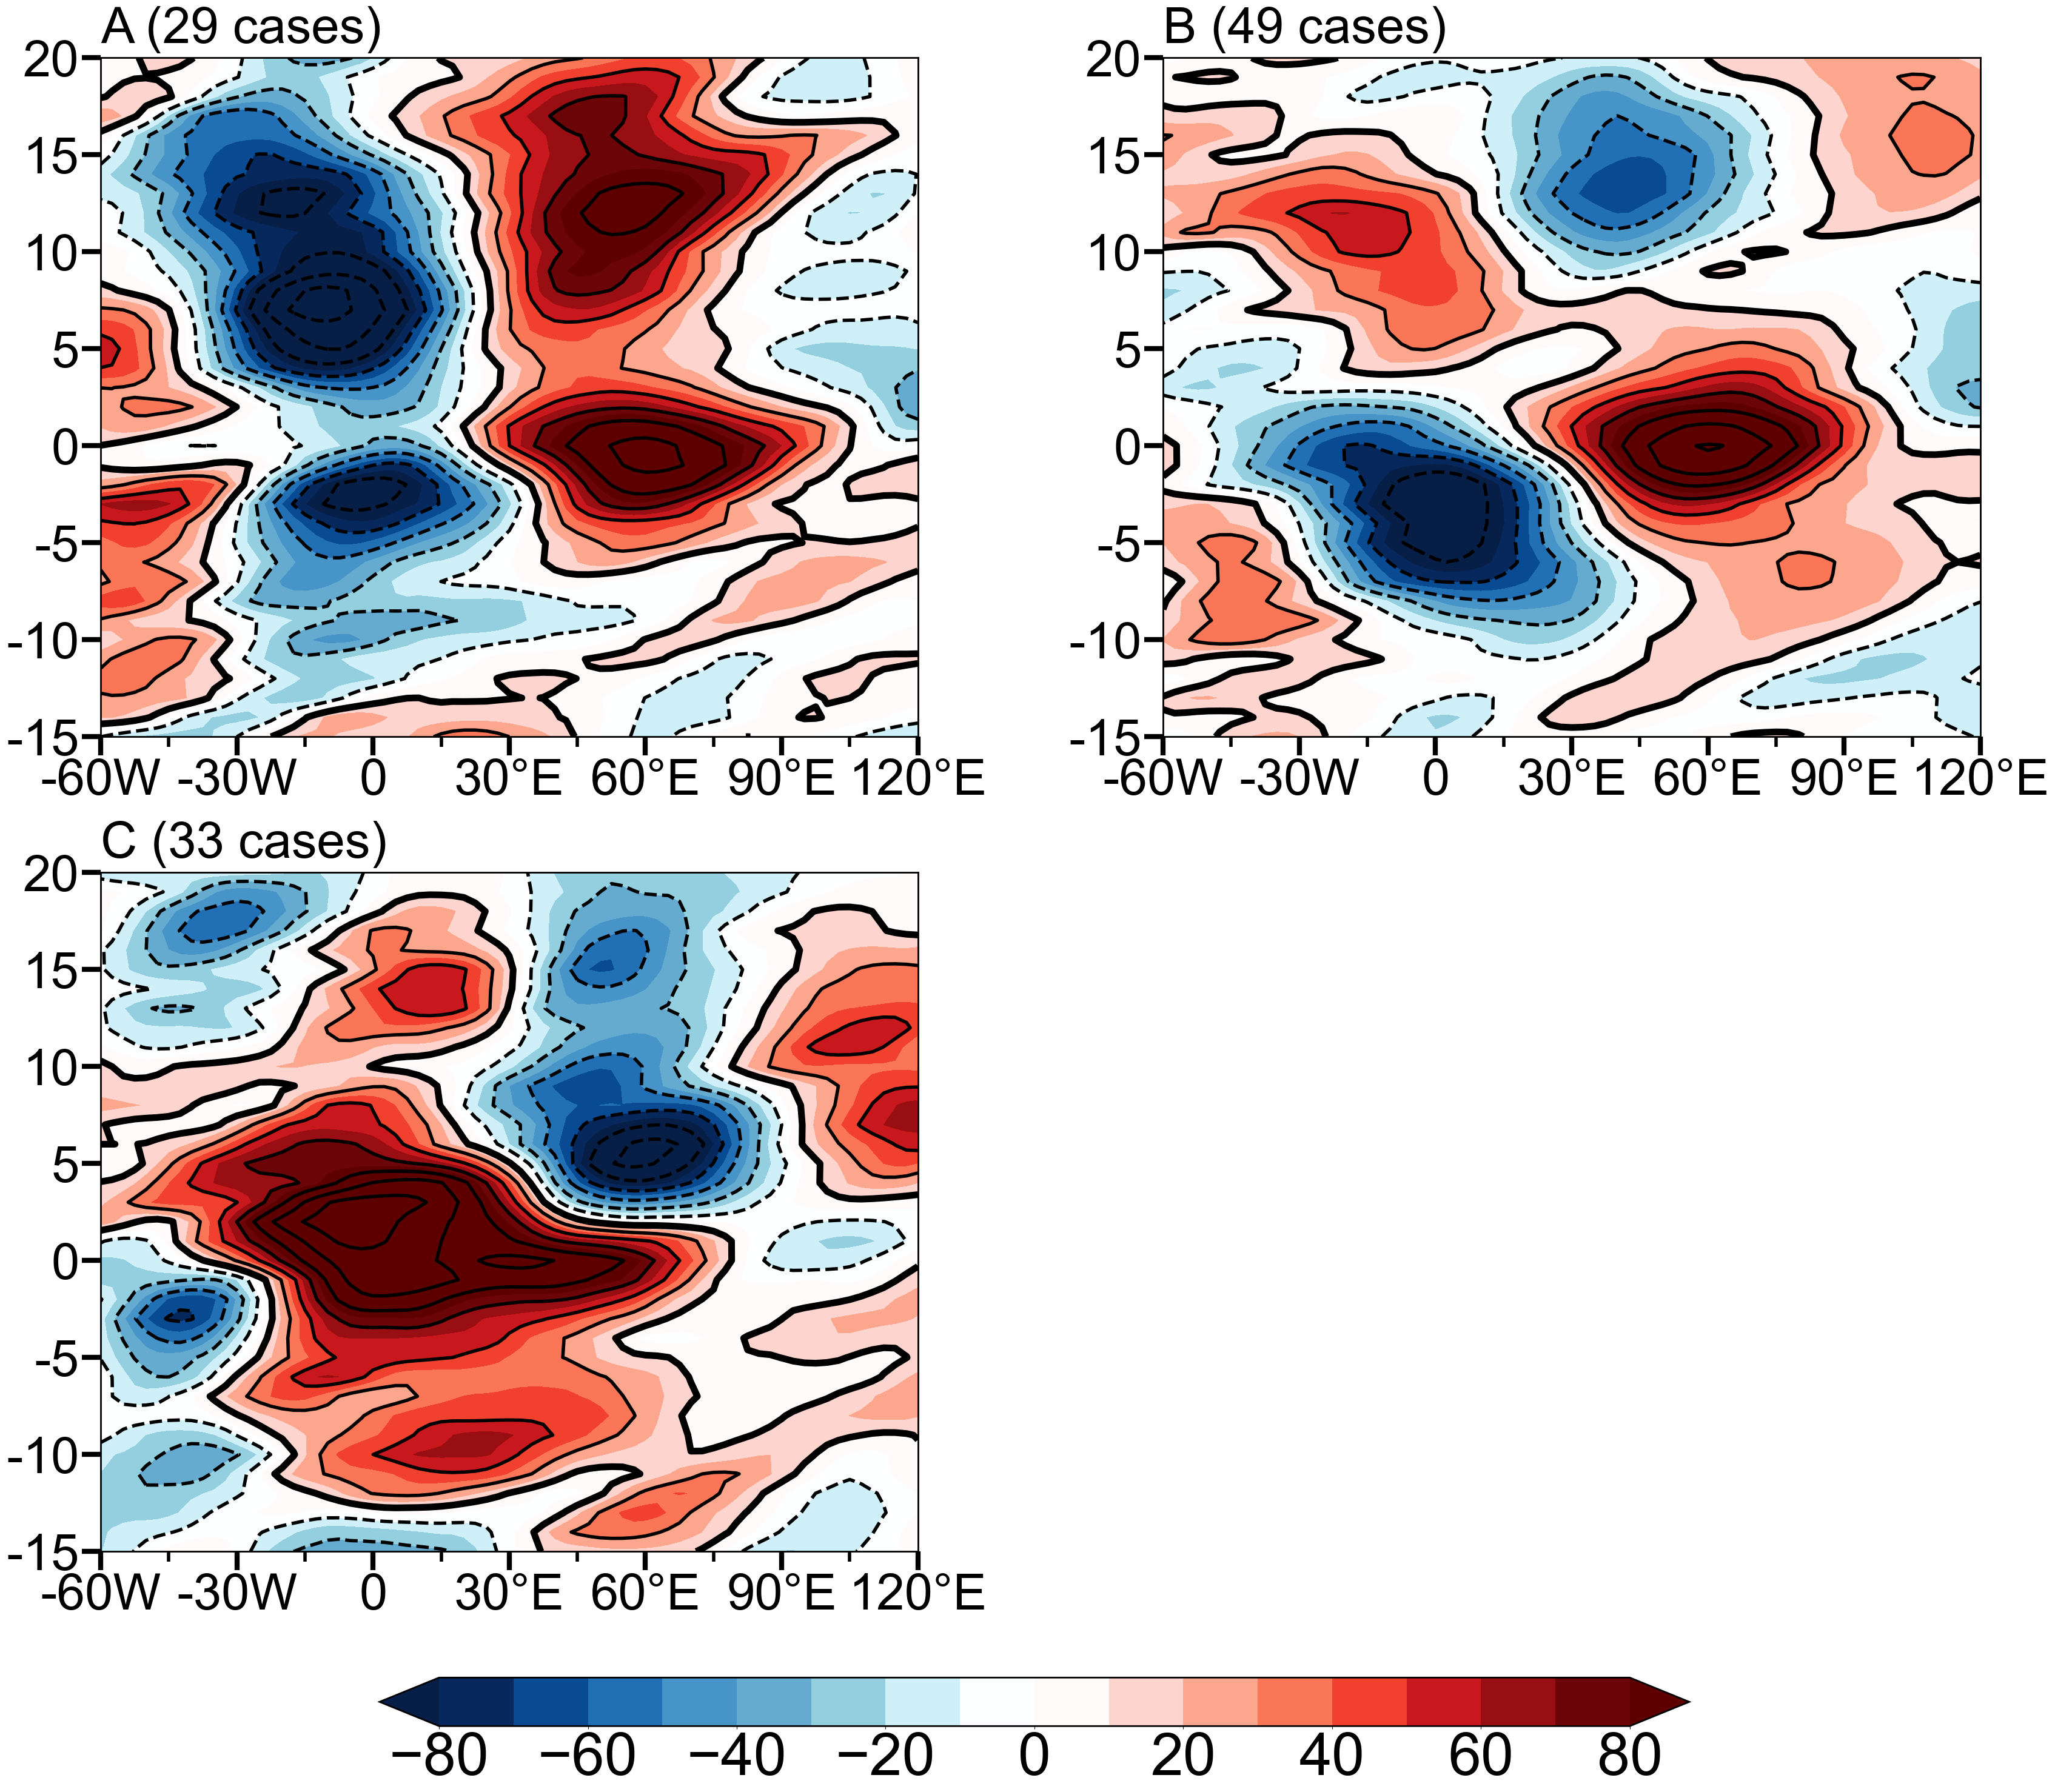

In [10]:
cluster_data = Z500_event_center_31_kmeans.copy()
som = MiniSom(x=1, y=3, input_len=1274,neighborhood_function="gaussian", sigma=2, learning_rate=0.5,random_seed=42)
# 创建一个 5x5 的 SOM
# x: 竞争层的X维度
# y: 竞争层的y维度
# input_len: 输入层的维度
# neighborhood_function：近邻函数，可选择：'gaussian', 'mexican_hat', 'bubble', 'triangle'
# sigma： 近邻函数的参数
# topology： 拓扑关系，默认是矩形关系。候选：'euclidean', 'cosine', 'manhattan', 'chebyshev'
# decay_function : 学习率的下降函数  降低学习率与缩小扩展范围使用的是同一个函数
#                   默认：(default=None) ： learning_rate / (1+t/(max_iterarations/2)
"""训练网络"""
som.train(cluster_data, 10000)


winner_coordinates = np.array([som.winner(x) for x in cluster_data])
cluster_index = np.ravel_multi_index(winner_coordinates.T, (1,3))
from sklearn.metrics import silhouette_samples, silhouette_score
silhouette_avg = silhouette_score(cluster_data, cluster_index)
print(f'轮廓系数: {silhouette_avg}')

Z500_event_center_mean_all_remv=Z500_event_center_mean_all.copy()
som_cluster_index=list(cluster_index)
event_according=list(np.arange(len(Z500_event_time_center))+1)
for cla in np.where(silhouette_samples(cluster_data, cluster_index)< 0.01)[0][::-1]:
    Z500_event_center_mean_all_remv.pop(cla)
    som_cluster_index.pop(cla)
    event_according.pop(cla)
som.labels_chr=[chr(ord('a')+som_cluster_index[i]) for i in range(len(som_cluster_index))]
event_filter=np.column_stack((event_according, som.labels_chr))
som_cluster_index=np.array(som_cluster_index)
print(f'筛选后事件: {event_filter}')

cluster1_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(som_cluster_index==0)[0]],dim='time').values.reshape(-1,36,73).mean(0)
cluster2_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(som_cluster_index==1)[0]],dim='time').values.reshape(-1,36,73).mean(0)
cluster3_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(som_cluster_index==2)[0]],dim='time').values.reshape(-1,36,73).mean(0)

fig = plt.figure(figsize=(40,32))
plt.subplots_adjust(wspace=0.3)
rcParams["axes.linewidth"] = 2
rcParams['font.family'] = 'Arial'

rcParams['hatch.linewidth'] = 3  # 控制点的线宽
rcParams['hatch.color'] = 'black'  # 修改图案颜色
temperature_cmap = cmaps.temp_19lev
# 获取该色图的颜色
colors = temperature_cmap(np.linspace(0, 1, temperature_cmap.N))

# 让中间两个颜色成为白色
midpoint = len(colors) // 2  # 找到色图的中间位置
colors[midpoint-1:midpoint+1] = np.array([1, 1, 1, 1])  # 设置中间的两个颜色为白色

# 创建新的色图
temperature_cmap = mcolors.LinearSegmentedColormap.from_list("custom_temp", colors)

ax = fig.add_subplot(2,2,1)
ax.set_title('A ('+str(np.where(som_cluster_index==0)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap ,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)


ax = fig.add_subplot(2,2,2)
ax.set_title('B ('+str(np.where(som_cluster_index==1)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
c1 = ax.contourf(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)


ax = fig.add_subplot(2,2,3)
ax.set_title('C ('+str(np.where(som_cluster_index==2)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
c1 = ax.contourf(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)
cb_ax = fig.add_axes([0.24, 0.02, 0.54, 0.025])  # [左, 下, 宽, 高]
cb = fig.colorbar(c1, ax=ax,cax=cb_ax,orientation='horizontal', fraction=0.05, pad=0.1) #extendrect=True
cb.ax.tick_params(labelsize=70)
cb.set_ticks(np.arange(-80,81,20))
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_DJF\Ural_blocking_Som_cluster_3.jpg',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_DJF\Ural_blocking_Som_cluster_3.pdf',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_DJF\Ural_blocking_Som_cluster_3.eps',dpi=300,bbox_inches='tight')

# 5类

轮廓系数: 0.037543963905034894
筛选后事件: [[  1   2]
 [  2   0]
 [  3   3]
 [  4   4]
 [  6   2]
 [  7   3]
 [  8   1]
 [  9   2]
 [ 10   3]
 [ 11   4]
 [ 12   3]
 [ 13   2]
 [ 15   4]
 [ 16   3]
 [ 17   1]
 [ 18   2]
 [ 20   0]
 [ 22   3]
 [ 23   2]
 [ 24   3]
 [ 25   4]
 [ 26   0]
 [ 27   2]
 [ 28   0]
 [ 29   1]
 [ 30   1]
 [ 31   2]
 [ 32   3]
 [ 33   4]
 [ 34   4]
 [ 35   1]
 [ 36   1]
 [ 37   3]
 [ 38   4]
 [ 39   1]
 [ 40   1]
 [ 41   2]
 [ 43   4]
 [ 44   0]
 [ 48   1]
 [ 50   1]
 [ 51   2]
 [ 52   2]
 [ 53   0]
 [ 57   4]
 [ 58   4]
 [ 59   0]
 [ 60   0]
 [ 61   1]
 [ 63   0]
 [ 64   2]
 [ 65   2]
 [ 66   3]
 [ 67   0]
 [ 68   2]
 [ 69   1]
 [ 70   0]
 [ 71   0]
 [ 73   1]
 [ 75   2]
 [ 76   4]
 [ 77   0]
 [ 79   2]
 [ 80   2]
 [ 82   0]
 [ 83   4]
 [ 84   3]
 [ 86   4]
 [ 87   2]
 [ 90   4]
 [ 91   1]
 [ 92   1]
 [ 93   3]
 [ 94   0]
 [ 95   2]
 [ 96   0]
 [ 97   4]
 [ 99   1]
 [101   2]
 [103   2]
 [104   0]
 [105   2]
 [106   2]
 [107   0]
 [108   0]
 [109   1]
 [111   3]
 [113   1

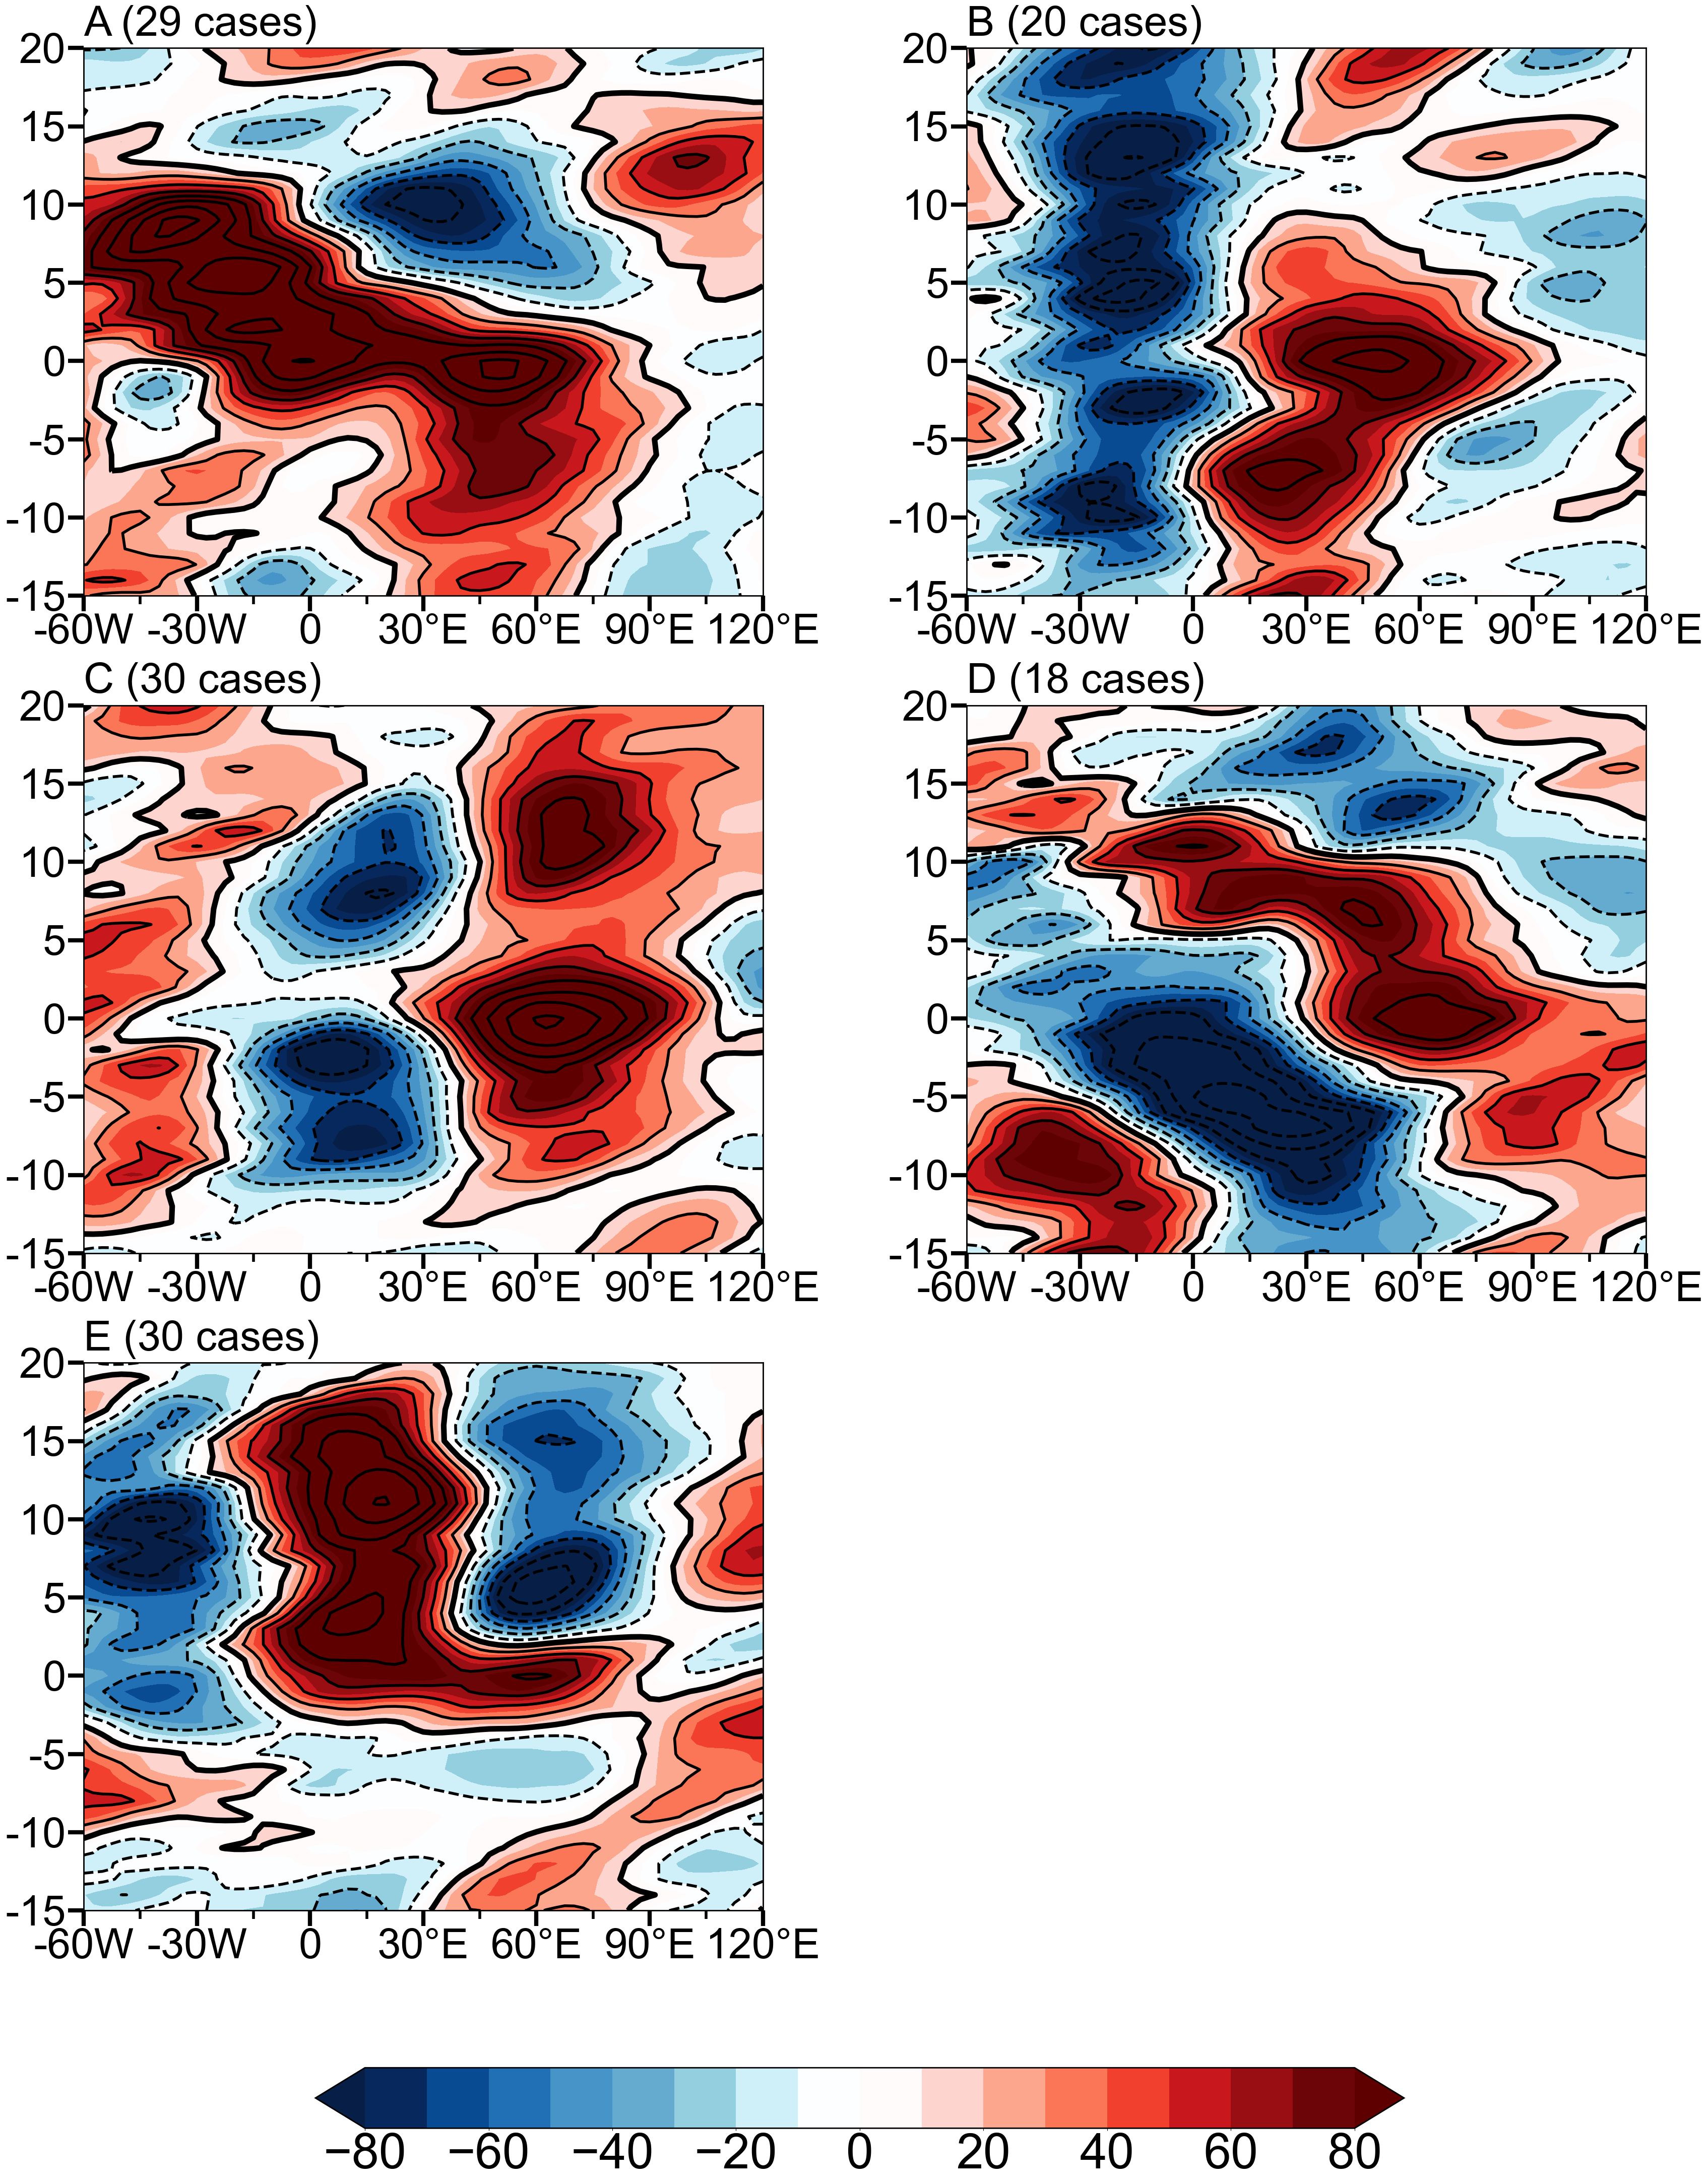

In [11]:
cluster_data = Z500_event_center_31_kmeans.copy()
som = MiniSom(x=1, y=5, input_len=1274,neighborhood_function="gaussian", sigma=2, learning_rate=0.5,random_seed=42)
# 创建一个 5x5 的 SOM
# x: 竞争层的X维度
# y: 竞争层的y维度
# input_len: 输入层的维度
# neighborhood_function：近邻函数，可选择：'gaussian', 'mexican_hat', 'bubble', 'triangle'
# sigma： 近邻函数的参数
# topology： 拓扑关系，默认是矩形关系。候选：'euclidean', 'cosine', 'manhattan', 'chebyshev'
# decay_function : 学习率的下降函数  降低学习率与缩小扩展范围使用的是同一个函数
#                   默认：(default=None) ： learning_rate / (1+t/(max_iterarations/2)
"""训练网络"""
som.train(cluster_data, 10000)


winner_coordinates = np.array([som.winner(x) for x in cluster_data])
cluster_index = np.ravel_multi_index(winner_coordinates.T, (1,5))
from sklearn.metrics import silhouette_samples, silhouette_score
silhouette_avg = silhouette_score(cluster_data, cluster_index)
print(f'轮廓系数: {silhouette_avg}')

Z500_event_center_mean_all_remv=Z500_event_center_mean_all.copy()
som_cluster_index=list(cluster_index)
event_according=list(np.arange(len(Z500_event_time_center))+1)
for cla in np.where(silhouette_samples(cluster_data, cluster_index)< 0.000)[0][::-1]:
    Z500_event_center_mean_all_remv.pop(cla)
    som_cluster_index.pop(cla)
    event_according.pop(cla)
som.labels_chr=[chr(ord('a')+som_cluster_index[i]) for i in range(len(som_cluster_index))]
event_filter=np.column_stack((event_according, som.labels_chr))
som_cluster_index=np.array(som_cluster_index)
print(f'筛选后事件: {event_filter}')

cluster1_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(som_cluster_index==0)[0]],dim='time').values.reshape(-1,36,73).mean(0)
cluster2_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(som_cluster_index==1)[0]],dim='time').values.reshape(-1,36,73).mean(0)
cluster3_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(som_cluster_index==2)[0]],dim='time').values.reshape(-1,36,73).mean(0)
cluster4_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(som_cluster_index==3)[0]],dim='time').values.reshape(-1,36,73).mean(0)
cluster5_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(som_cluster_index==4)[0]],dim='time').values.reshape(-1,36,73).mean(0)


fig = plt.figure(figsize=(40,48))
plt.subplots_adjust(wspace=0.3)
rcParams["axes.linewidth"] = 2
rcParams['font.family'] = 'Arial'

rcParams['hatch.linewidth'] = 3  # 控制点的线宽
rcParams['hatch.color'] = 'black'  # 修改图案颜色
temperature_cmap = cmaps.temp_19lev
# 获取该色图的颜色
colors = temperature_cmap(np.linspace(0, 1, temperature_cmap.N))

# 让中间两个颜色成为白色
midpoint = len(colors) // 2  # 找到色图的中间位置
colors[midpoint-1:midpoint+1] = np.array([1, 1, 1, 1])  # 设置中间的两个颜色为白色

# 创建新的色图
temperature_cmap = mcolors.LinearSegmentedColormap.from_list("custom_temp", colors)

ax = fig.add_subplot(3,2,1)
ax.set_title('A ('+str(np.where(som_cluster_index==0)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap ,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)


ax = fig.add_subplot(3,2,2)
ax.set_title('B ('+str(np.where(som_cluster_index==1)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
c1 = ax.contourf(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)


ax = fig.add_subplot(3,2,3)
ax.set_title('C ('+str(np.where(som_cluster_index==2)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
c1 = ax.contourf(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)

ax = fig.add_subplot(3,2,4)
ax.set_title('D ('+str(np.where(som_cluster_index==3)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,np.arange(1,37), cluster4_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster4_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster4_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster4_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)

ax = fig.add_subplot(3,2,5)
ax.set_title('E ('+str(np.where(som_cluster_index==2)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,np.arange(1,37), cluster5_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster5_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster5_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster5_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)

cb_ax = fig.add_axes([0.24, 0.02, 0.54, 0.025])  # [左, 下, 宽, 高]
cb = fig.colorbar(c1, ax=ax,cax=cb_ax,orientation='horizontal', fraction=0.05, pad=0.1) #extendrect=True
cb.ax.tick_params(labelsize=70)
cb.set_ticks(np.arange(-80,81,20))
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_DJF\Ural_blocking_Som_cluster_5.jpg',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_DJF\Ural_blocking_Som_cluster_5.pdf',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_DJF\Ural_blocking_Som_cluster_5.eps',dpi=300,bbox_inches='tight')